In [32]:
# Библиотеки
import cv2
import supervision as sv
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from collections import Counter # Импортируем Counter для подсчета классов

# Подготовка данных

In [33]:
# Пример возьмём изображение животного из интернета
image_url = "https://fonowik.club/uploads/posts/2023-01/1673351069_16-fonowik-club-p-sobaki-svetyashchiesya-glaza-v-nochi-21.jpg"

# Авторизация в Roboflow

In [34]:
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com", # серверлесс-инфраструктура  Roboflow.
    api_key="E9xD9ykxphgEqrFwuuki" # мой личный API ключ, который необходим для аутентификации запроса.
)

# Выполнение инференса

In [35]:
result = client.run_workflow(
    workspace_name="s-workspace-mrfmi",
    workflow_id="find-foxes-wolves-lynxes-bears-and-wild-boars",
    images={
        "image": image_url
    },
    use_cache=False 
)

# Загрузка и конвертация изображения

In [36]:
# Для визуализации нам нужно само изображение, а не ссылка.
# requests.get скачивает байты изображения.
response = requests.get(image_url)

# BytesIO превращает байты в файловый объект, понятный библиотеке PIL.
# .convert("RGB") гарантирует, что картинка будет в стандартном цветовом формате (без альфа-канала).
image = Image.open(BytesIO(response.content)).convert("RGB")

# Превращаем PIL-изображение в NumPy-массив, потому что библиотека supervision и OpenCV работают с массивами.
image_np = np.array(image)

# арсинг) ---

In [37]:
# Результат от API приходит в виде списка словарей (по одному на каждое отправленное изображение).
# Мы отправляли одно изображение, поэтому берем result[0].
prediction_data = result[0]

# Библиотека supervision (sv) значительно упрощает работу с результатами нейросетей.
# sv.Detections.from_inference автоматически разбирает сложный JSON-ответ от Roboflow.
# Он извлекает координаты рамок (bounding boxes), классы и уверенность модели.
# Важно: "predictions" - это ключ в словаре prediction_data, содержащий результаты детекции.
detections = sv.Detections.from_inference(prediction_data["predictions"])

# Настройка визуализации

In [38]:
# BoxAnnotator отвечает за рисование прямоугольников вокруг найденных объектов.
box_annotator = sv.BoxAnnotator()

# LabelAnnotator отвечает за размещение текста (названия класса) над рамкой.
label_annotator = sv.LabelAnnotator()

# Формирование списка подписей.
# zip(...) объединяет имена классов и уверенность модели для каждого обнаруженного объекта.
# f-строка форматирует текст: "bird 0.85" (имя + уверенность с двумя знаками после запятых).
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections.data["class_name"], detections.confidence)
]

# Отрисовка на изображении

In [39]:
# Сначала рисуем рамки на копии исходного изображения (image_np.copy()).
# Копия нужна, чтобы не "портить" исходный массив данных, если он понадобится позже чистым.
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)

# Затем поверх рамок добавляем текстовые метки, используя labels, созданные выше.
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

# Вывод результатов

ВНИМАНИЕ! В близости от вашего хозяйства замечены fox в количестве 1 особей.


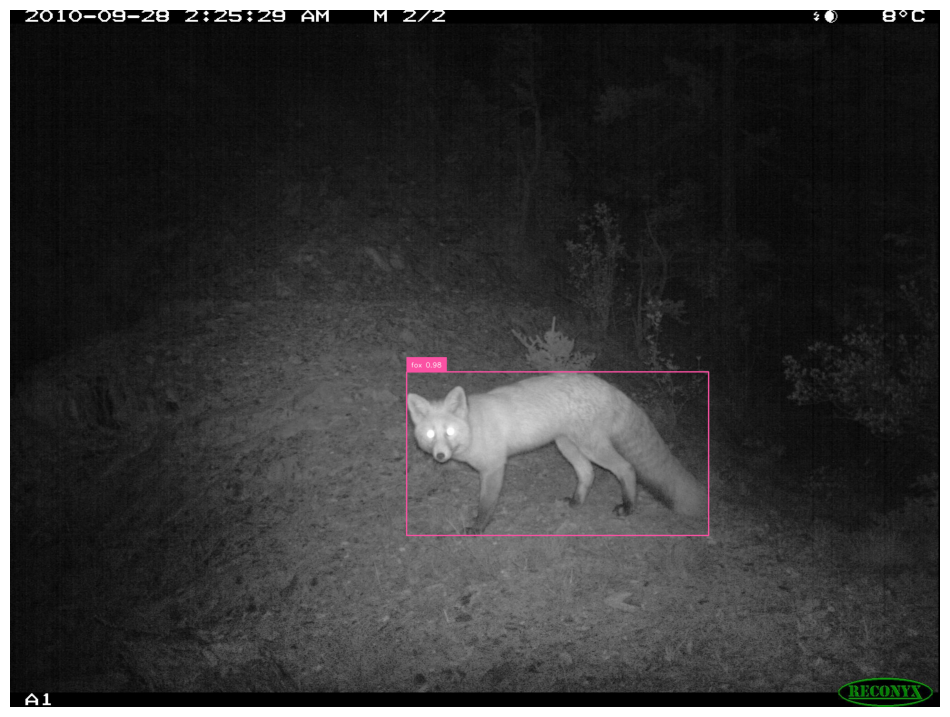

In [43]:
# 1. Получаем общее количество обнаруженных особей.
total_count = len(detections)

if total_count > 0:
    # 2. Получаем список всех распознанных классов.
    class_names = detections.data["class_name"]
    
    # 3. Считаем, какое название животного встречается чаще всего (наиболее репрезентативное).
    # Counter создает словарь вида {'имя_класса': количество, ...}
    # most_common(1) возвращает список с одним элементом: [('самый_частый_класс', количество)]
    most_common_class = Counter(class_names).most_common(1)[0][0]
    
    # 4. Форматируем вывод.
    output_message = f"ВНИМАНИЕ! В близости от вашего хозяйства замечены {most_common_class} в количестве {total_count} особей."
else:
    output_message = "Животные на изображении не обнаружены."

# Вывод текстовой статистики.
print(output_message)

# Используем Matplotlib для показа изображения прямо в Jupyter Notebook или окне IDE.
plt.figure(figsize=(12, 12)) # Задаем большой размер фигуры для четкости.
plt.imshow(annotated_image)
plt.axis('off') # Убираем оси координат (пиксельную линейку), чтобы было красивее.
plt.show()